In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.decomposition import PCA
from tensorflow import keras 
from keras import Sequential
from keras.layers import Dense
import joblib
from sklearn.metrics import confusion_matrix, f1_score, classification_report, balanced_accuracy_score, cohen_kappa_score
from keras.wrappers.scikit_learn import KerasClassifier
import eli5
from eli5.sklearn import PermutationImportance
import matplotlib.pyplot as plt

C:\Miniconda38\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Miniconda38\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
def saveModel(model, filename):
    model.save(filename)

def loadModel(filename):
    model = joblib.load(filename)
    return model

In [3]:
df = pd.read_csv("../data/[CLEANED]kepler-data.csv")
df.drop(columns = ["Unnamed: 0"], inplace=True)

In [4]:
ALL_COLUMNS = df.columns
ERROR_COLUMNS = [col for col in ALL_COLUMNS if "err" in col]
EXCLUDE = ["rowid", "kepid", "kepoi_name", "koi_score", "koi_disposition", "koi_pdisposition", "koi_tce_delivname", "koi_tce_plnt_num"] #+ ERROR_COLUMNS
TO_USE = list(set(ALL_COLUMNS) - set(EXCLUDE))

In [5]:
subset_df = df[df["koi_disposition"] != "CANDIDATE"]

In [6]:
X = subset_df[TO_USE].values
y = subset_df["koi_disposition"].apply(lambda x: x=='CONFIRMED').astype(int).values

In [7]:
X = StandardScaler().fit_transform(X)
X = PCA(n_components=30).fit_transform(X)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 0, stratify=y)

In [9]:
def createModel():
    model = Sequential([
                    Dense(256, activation = 'relu'),
                    Dense(128, activation = 'relu'),
                    Dense(128, activation = 'relu'),
                    Dense(1, activation = 'sigmoid')
                   ])
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

In [10]:
def performance(test, pred):
    conf_matrix = confusion_matrix(test, pred)
    f1 = f1_score(test, pred)
    report = classification_report(test, pred)
    accuracy = balanced_accuracy_score(test, pred)
    kappa = cohen_kappa_score(test, pred)
    print(f"F1 Score: {f1}")
    print(f"Kappa Score: {kappa}")
    print(f"Accuracy Score: {accuracy}")
    print(f"Confusion Matrix:\n{conf_matrix}")
    print(report)

In [11]:
def trainEvaluate(model, fold, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train, epochs=20, verbose=0)
    pred = model.predict(X_test)
    pred = pred >= 0.5
    f1 = f1_score(y_test, pred)
    print(f"F1 Score in fold {fold} = {f1}")
    return f1


def crossValidation(K=10):
    kFold = KFold(n_splits=K, shuffle=True, random_state=0)
    f1_scores = list()
    k_ctr = 1
    for train, test in kFold.split(X, y):
        model = None
        model = createModel()
        current_f1 = trainEvaluate(model, k_ctr, X[train], y[train], X[test], y[test])
        f1_scores.append(current_f1)
        k_ctr+=1
    print(f"Average {K}-Fold F1 Score = {np.mean(f1_scores)}\n")
    
    k_ctr = 1
    kFold = StratifiedKFold(n_splits=K, shuffle=True, random_state=0)
    f1_scores = list()
    for train, test in kFold.split(X, y):
        model = None
        model = createModel()
        current_f1 = trainEvaluate(model, k_ctr, X[train], y[train], X[test], y[test])
        f1_scores.append(current_f1)
        k_ctr+=1
    print(f"Average Stratified {K}-Fold F1 Score = {np.mean(f1_scores)}")

In [12]:
crossValidation(K=10)

F1 Score in fold 1 = 0.9749430523917996
F1 Score in fold 2 = 0.9836829836829836
F1 Score in fold 3 = 0.975609756097561
F1 Score in fold 4 = 0.9799554565701558
F1 Score in fold 5 = 0.9859813084112149
F1 Score in fold 6 = 0.9814432989690722
F1 Score in fold 7 = 0.9813664596273292
F1 Score in fold 8 = 0.9736842105263159
F1 Score in fold 9 = 0.9836734693877551
F1 Score in fold 10 = 0.9842696629213483
Average 10-Fold F1 Score = 0.9804609658585537

F1 Score in fold 1 = 0.9826839826839827
F1 Score in fold 2 = 0.986842105263158
F1 Score in fold 3 = 0.9665924276169265
F1 Score in fold 4 = 0.9674620390455532
F1 Score in fold 5 = 0.9823008849557523
F1 Score in fold 6 = 0.9870129870129871
F1 Score in fold 7 = 0.9934354485776805
F1 Score in fold 8 = 0.9848156182212581
F1 Score in fold 9 = 0.986842105263158
F1 Score in fold 10 = 0.9801324503311258
Average Stratified 10-Fold F1 Score = 0.9818120048971583


In [13]:
model = createModel()
model.fit(X_train, y_train, epochs=20, verbose=0)
pred = model.predict(X_test)
pred = pred >= 0.5

In [14]:
performance(y_test, pred)

F1 Score: 0.982083609820836
Kappa Score: 0.9732975515629764
Accuracy Score: 0.9858325917647952
Confusion Matrix:
[[1523   11]
 [  16  740]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1534
           1       0.99      0.98      0.98       756

    accuracy                           0.99      2290
   macro avg       0.99      0.99      0.99      2290
weighted avg       0.99      0.99      0.99      2290



In [15]:
saveModel(model, "../model/nn-model-error.h5")

In [16]:
model = KerasClassifier(build_fn=createModel, epochs=20, verbose=0)
model.fit(X, y)
perm = PermutationImportance(model, random_state=0).fit(X,y)
eli5.show_weights(perm, feature_names = [f"Component {i+1}" for i in range(X.shape[1])])

Weight,Feature
0.1089 ± 0.0036,Component 4
0.0797 ± 0.0065,Component 8
0.0539 ± 0.0022,Component 1
0.0319 ± 0.0023,Component 6
0.0315 ± 0.0020,Component 17
0.0278 ± 0.0007,Component 14
0.0250 ± 0.0040,Component 2
0.0187 ± 0.0037,Component 9
0.0157 ± 0.0027,Component 10
0.0127 ± 0.0026,Component 18


In [17]:
perm.feature_importances_

array([0.05392708, 0.02498918, 0.0011529 , 0.10892057, 0.00510159,
       0.03190658, 0.00291107, 0.07966565, 0.01870584, 0.01565065,
       0.00389104, 0.00564922, 0.00469807, 0.02775613, 0.00556275,
       0.0028246 , 0.03147426, 0.01265311, 0.00144111, 0.00337223,
       0.01020318, 0.00515922, 0.00743623, 0.00501513, 0.0011529 ,
       0.00135465, 0.00121053, 0.00181581, 0.00279577, 0.0018158 ])

In [18]:
order = np.argsort(perm.feature_importances_)[::-1]
sorted_importances = sorted(perm.feature_importances_, reverse = True)
sorted_features = np.asarray([f"{i+1}" for i in range(X.shape[1])])[order]
feature_importance_df = pd.DataFrame()
feature_importance_df['Features'] = sorted_features
feature_importance_df['Importance'] = sorted_importances

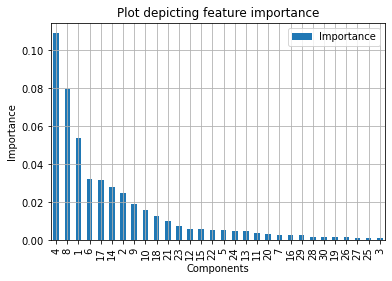

In [19]:
feature_importance_df.plot(x = 'Features', y = 'Importance', kind = 'bar')
plt.title('Plot depicting feature importance')
plt.grid()
plt.xlabel('Components')
plt.ylabel('Importance')
plt.show()